# Linear Least Squares

## Problem statement:

Given a large set of 2D measurement points $(u_{i}, v_{i})$ (in data.csv) approximate these points by a circle with radius $r$ and center $(u_{c}, v_{c})$ as well as possible.

## Approach:

The problem is overdetermined, as it has 50 measurements to determine 3 parameters, and such only approximate solution that minimizes some property can be achieved. The solution is obtained by linear least squares by minimizing the square of the radius:

The distance of the measurement point $i$ from the center of the circle is

$$ \sqrt{(u_{i} - u_{c})^2 + (v_{i}-v_{c})^2} \approx r $$

To formulate a *linear* least squares problem, it is best to minimize the fourth power of the distances, rather than the square. This results in the problem forumlation of

$$ \min \left(\sum_{i=1}^{m} \left((u_{i} - u_{c})^2 + (v_{i}-v_{c})^2 - r^2\right)^2\right) $$

Introducing an auxiliary variable $w := u_{c}^2 + v_{c}^2 - r^2 $ and expanding the squares of differences, we obtain

$$
\begin{align}
(u_{i} - u_{c})^2 + (v_{i} - v_{c})^2 - r^2
&= u_{i}^2 - 2u_{i}u_{c} + u_{c}^2 + v_{i}^2 - 2v_{i}v_{c} + v_{c}^2 - r^2 \\
&= u_{i}^2 -2u_{i}u_{c} + v_{i}^2 - 2v_{i}v_{c} + w
\end{align}
$$

This leads to the least squares formulation of the problem in matrix form:

$$
\min_{u_{c},v_{c},w}
\begin{Vmatrix}
\begin{pmatrix}
-2u_{1} & -2v_{1} & 1 \\
-2u_{2} & -2v_{2} & 1 \\
\vdots & \vdots & \vdots \\
-2u_{m} & -2v_{m} & 1
\end{pmatrix}
\begin{pmatrix}
u_{c}\\
v_{c}\\
w
\end{pmatrix}
-
\begin{pmatrix}
u_1^2 + v_1^2 \\
u_2^2 + v_2^2 \\
\vdots \\
u_m^2 + v_m^2
\end{pmatrix}
\end{Vmatrix}
_2^2
$$

Note: the above currently does not render quite correctly on Github as opposed to running the notebook locally

## Solution

First read the csv file as a numpy array

In [1]:
import numpy as np

data = np.loadtxt('data.csv', delimiter=',')
u = data[:, [0]]
v = data[:, [1]]

print('First few data points:')
data[:5, :]

First few data points:


array([[-3.9265,  5.7992],
       [-3.1716,  7.3131],
       [-1.6116,  7.5592],
       [-2.6679,  7.6911],
       [-1.73  ,  5.5113]])

A quick plot of the data reveals that the measured data indeed seem to be arranged in roughly a circle:

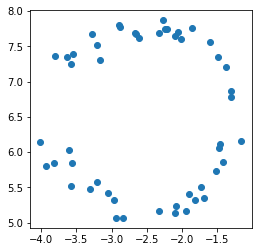

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(u, v, 'o');

Construct the matrices $A$ and $b$ for minimizing the least squares problem of the form
$$
\min_{x^*}
\begin{Vmatrix}
Ax^* - b
\end{Vmatrix}_2^2 , \\
A \in \mathbb{R}^{m \times n}, b \in \mathbb{R}^m, m \gg n
$$

In [3]:
def construct_A(u: np.ndarray, v: np.ndarray) -> np.ndarray:
    m = u.shape[0]
    A = np.hstack((-2*np.hstack((u, v)), np.ones((m, 1))))
    return A


def construct_b(u: np.ndarray, v: np.ndarray) -> np.ndarray:
    b = -np.square(u) - np.square(v)
    return b


A = construct_A(u, v)
b = construct_b(u, v)

In [4]:
def back_substitution(U: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Perform back substitution to solve a matrix equation

    Arguments:
    U -- an np.ndarray upper right triangular matrix of shape (n, n)
    b -- an np.ndarray of shape (n, 1)
    """
    n = b.size
    x = np.zeros_like(b)

    x[-1] = b[-1]/U[-1, -1]
    for i in range(n-2, -1, -1):
        x[i] = (b[i] - np.dot(U[i, i+1:n], x[i+1:n]))/U[i, i]

    return x


def least_squares_qr(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Solve the linear least squares problem with QR-decomposition

    Arguments:
    A -- an np.ndarray of shape (m, n), with m >> n
    b -- an np.ndarray of shape (m, 1)
    """
    from scipy import linalg
    q, r = linalg.qr(A)

    y = np.dot(q.T, b)
    n = A.shape[1]
    y = y[0:n, :]
    r = r[0:n, :]

    x = back_substitution(r, y)
    # should really just use:
    # x = linalg.solve_triangular(r, y)
    return x


x = least_squares_qr(A, b)

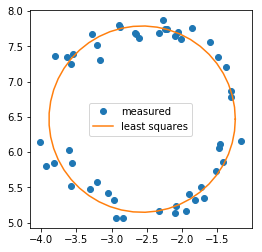

In [5]:
def plot_results(u, v, x):
    uc, vc, w = x
    # calculate r from the definition of w above
    r = (uc**2 + vc**2 - w)**0.5

    theta = np.linspace(0., 2*np.pi)
    x = r*np.cos(theta) + uc
    y = r*np.sin(theta) + vc

    fix, ax = plt.subplots()
    ax.plot(u, v, 'o', label='measured')
    ax.plot(x, y, label='least squares')
    ax.set_aspect('equal')
    ax.legend()


plot_results(u, v, x)